# Import The Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from shekar import Normalizer, WordTokenizer
from shekar.preprocessing import StopWordRemover, PunctuationRemover

### Load Datasest

In [ ]:
df = pd.read_csv("cleaned.csv")

### Prepare & Perform Pre-Processing

In [ ]:
normalizer = Normalizer()
pipeline = StopWordRemover() | PunctuationRemover()
tokenizer = WordTokenizer()

In [ ]:
def preprocess_comment(text):
    text = "" if pd.isna(text) else str(text)
    text = normalizer(text)
    text = pipeline(text)
    tokens = list(tokenizer(text))
    return " ".join(tokens)

### Skip Some Unnecessary Cases

In [ ]:
p1 = 'چیز اضافه'
p2 = 'چیزی اضافه'
pattern = f'({p1}|{p2})'

mask = ((df['comment_text'].str.contains(pattern, na=False) &(df['comment_text'].str.len() < 20))|
    (df['comment_text'].str.len() < 5))

df['comment_clean'] = np.where(mask ,df['comment_text'],df['comment_text'].astype(str).apply(preprocess_comment))

### Load Model

In [ ]:
MODEL = "HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-multi"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

use_cuda = torch.cuda.is_available()
device = 0 if use_cuda else -1
if use_cuda:
    model = model.to("cuda")

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    truncation=True
)

### Execute The Model

In [ ]:
texts = df.loc[~mask, 'comment_clean'].fillna("").astype(str).tolist()

batch_size = 32
results = sentiment_pipe(texts, batch_size=batch_size)

### Collect Results In A Proper Way

In [ ]:
raw_labels = [r['label'] for r in results]
scores = [r.get('score', None) for r in results]

In [ ]:
def map_label_to_num(raw_label):
    L = raw_label
    if "happy" in L or 'delighted' in L:
        return 1
    if 'furious' in L or 'angry' in L:
        return -1
    return 0

In [ ]:
df['sentiment'] = 0
df['sentiment_score'] = 1

mapped = [map_label_to_num(l) for l in raw_labels]

df.loc[~mask, 'sentiment'] = mapped
df['sentiment'] = df['sentiment'].astype(int)

df.loc[~mask, 'sentiment_score'] = scores
df['sentiment_score'] = df['sentiment_score'].round(3)


### Show Some Samples

In [ ]:
df[['comment_clean', 'sentiment', 'sentiment_score']].head(10)

### Save Locally for Better and Faster Results

In [ ]:
df.to_csv("final.csv",index=False, encoding="utf-8-sig")

### Continue Task Locally From Here

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (8,5)

In [19]:
df = pd.read_csv("final.csv")

In [20]:
sent_counts = df['sentiment'].value_counts().sort_index() 

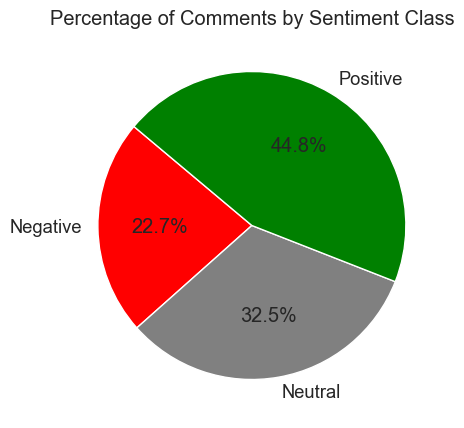

In [21]:
plt.pie(
    sent_counts.values,
    labels=["Negative","Neutral","Positive"],
    autopct="%1.1f%%",
    colors=["red","gray","green"],
    startangle=140
)
plt.title("Percentage of Comments by Sentiment Class")
plt.show()


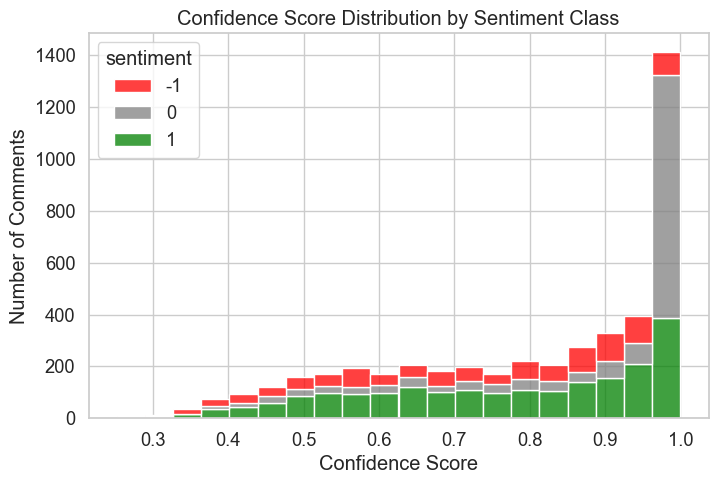

In [22]:
sns.histplot(
    data=df,
    x='sentiment_score',
    hue='sentiment',
    bins=20,
    palette={-1:"red",0:"gray",1:"green"},
    multiple="stack"
)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Comments")
plt.title("Confidence Score Distribution by Sentiment Class")
plt.show()

In [23]:
profs = df['professor'].astype(str).unique().tolist()
profs.sort()

In [ ]:
# Settings
TEXT_COL = "comment_clean"
GROUP_COL = "professor"
TOP_N = 30
font_path = r"C:\Windows\Fonts\aldhabi.ttf"

profs = df[GROUP_COL].astype(str).unique().tolist()
profs.sort()

def show_professor(prof):
    clear_output(wait=True)
    display(dropdown)  # keep the dropdown visible

    prof_df = df[df[GROUP_COL].astype(str) == str(prof)]
    docs = prof_df[TEXT_COL].fillna("").astype(str).tolist()
    if len(docs) == 0:
        print("No comments for this professor.")
        return

    big_doc = " . ".join(docs)

    # TF-IDF
    tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000, token_pattern=r"(?u)\b\w+\b")
    tfidf_vec = tfidf.fit_transform([big_doc])
    names = tfidf.get_feature_names_out()
    scores = tfidf_vec.toarray().ravel()
    tfidf_idx = np.argsort(scores)[::-1][:TOP_N]
    tfidf_terms = [(names[i], float(scores[i])) for i in tfidf_idx if scores[i] > 0]

    # Frequency
    count = CountVectorizer(ngram_range=(1,2), max_features=5000, token_pattern=r"(?u)\b\w+\b")
    count_vec = count.fit_transform([big_doc])
    cnames = count.get_feature_names_out()
    ccounts = count_vec.toarray().ravel()
    count_idx = np.argsort(ccounts)[::-1][:TOP_N]
    count_terms = [(cnames[i], int(ccounts[i])) for i in count_idx if ccounts[i] > 0]

    freq_dict = {t:s for t,s in (tfidf_terms if len(tfidf_terms)>0 else count_terms)}

    kw_df = pd.DataFrame(tfidf_terms if len(tfidf_terms)>0 else count_terms, columns=['term','score'])
    display(kw_df.head(TOP_N).T)

    # wordcloud
    wc = WordCloud(font_path=font_path, width=800, height=500, background_color="white", collocations=False)
    wc.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {prof}")
    plt.show()

In [ ]:
# interactive dropdown
dropdown = widgets.Dropdown(options=profs, description="Select professor:", value=profs[0])
widgets.interact(show_professor, prof=dropdown)

interactive(children=(Dropdown(description='Select professor:', options=('آتنا بروغنی', 'آذری', 'آرش سراحیان',…

<function __main__.show_professor(prof)>